In [9]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    MeshcatVisualizerCpp,
    MultilayerPerceptron,
    Parser,
    PerceptronActivationType,
    Simulator,
    StartMeshcat,
    ZeroOrderHold,
)
from underactuated import FindResource, running_as_notebook
from value_iteration import *
from functools import partial
import seaborn as sns
import pandas as pd

In [2]:
meshcat = StartMeshcat()

Meshcat is now available at http://localhost:7001


In [3]:
# Set up the cart-pole system
builder = DiagramBuilder()
cart_plant, cart_scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
file_name = FindResource("models/cartpole.urdf")
Parser(cart_plant).AddModelFromFile(file_name)
cart_plant.Finalize()
cart_plant_context = cart_plant.CreateDefaultContext()

cart_diagram = builder.Build()

num_states = cart_plant.num_continuous_states()
cart_actuation_port_index = 3
num_inputs = cart_plant.get_input_port(cart_actuation_port_index)

# Set up training data. states are (x, theta, x_dot, theta_dot)
time_step = 0.01
num_samples = 50
x_states_cart = np.linspace(-2, 2, num_samples)
theta_states_cart = np.linspace(0, 2 * np.pi, 50)
x_dot_states_cart = np.linspace(-10, 10, num_samples)
theta_dot_states_cart = np.linspace(-10, 10, num_samples)
state_grid_cart = np.meshgrid(
    x_states_cart,
    theta_states_cart,
    x_dot_states_cart,
    theta_dot_states_cart,
    indexing="ij",
)
state_data_cart = np.vstack([s.flatten() for s in state_grid_cart])

# zero cost state
cart_target_state = np.array([0, np.pi, 0, 0]).reshape(-1, 1)

Q_cart = np.diag([0.1, 20, 1, 1])
R_cart = np.array([2])

# A neural network for the cartpole
cart_value_mlp = MultilayerPerceptron(
    [False, True, False, False],
    [128, 128, 1],
    [
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kReLU,
        PerceptronActivationType.kIdentity,
    ],
)

state_cost_function_cart = partial(compute_state_cost, Q_cart, cart_target_state)
# train the neural network
(cart_value_mlp_context, loss_over_time) = ContinuousFittedValueIteration(
    cart_plant,
    cart_plant_context,
    cart_value_mlp,
    state_cost_function_cart,
    compute_u_star,
    R_cart,
    state_data_cart,
    time_step=0.01,
    discount_factor=0.9999,
    input_port_index=cart_actuation_port_index,
    lr=1e-4,
    minibatch=64,
    epochs=20,
    optimization_steps_per_epoch=100,
    input_limits=None,
    target_state=cart_target_state,
)

<AxesSubplot:xlabel='epoch', ylabel='loss'>

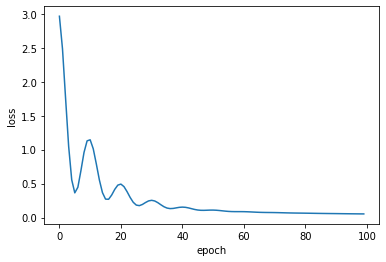

In [20]:
losses = pd.DataFrame({"epoch": range(len(loss_over_time)), "loss": loss_over_time})
sns.lineplot(x="epoch", y="loss", data=losses)

In [4]:
cart_value_mlp_context.get_continuous_state

<bound method PyCapsule.get_continuous_state of <pydrake.systems.framework.LeafContext_[float] object at 0x2a23edf70>>

In [5]:
# initialize controller and plant
diagram_builder = DiagramBuilder()

cart_plant_cl, cart_scene_graph_cl = AddMultibodyPlantSceneGraph(
    diagram_builder, time_step=0.0
)

file_name = FindResource("models/cartpole.urdf")
Parser(cart_plant_cl).AddModelFromFile(file_name)
cart_plant_cl.Finalize()
cart_plant_context_cl = cart_plant_cl.CreateDefaultContext()
cart_controller_sys = ContinuousFittedValueIterationPolicy(
    cart_plant_cl,
    cart_value_mlp,
    cart_value_mlp_context,
    R_cart,
    compute_u_star,
    input_port_index=cart_actuation_port_index,
)


cart_controller = diagram_builder.AddSystem(cart_controller_sys)
# we assume a zero-order hold between time steps
zoh_cart = diagram_builder.AddSystem(ZeroOrderHold(time_step, 1))

# wire all the systems together
diagram_builder.Connect(
    cart_plant_cl.get_state_output_port(), cart_controller.get_input_port()
)
diagram_builder.Connect(
    cart_controller.get_output_port(), zoh_cart.get_input_port()
)
diagram_builder.Connect(
    zoh_cart.get_output_port(), cart_plant_cl.get_input_port(cart_actuation_port_index)
)

meshcat.Delete()
meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
vis = MeshcatVisualizerCpp.AddToBuilder(
    diagram_builder, cart_scene_graph_cl, meshcat
)

simulator = Simulator(diagram_builder.Build())
simulator_context = simulator.get_mutable_context()

simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
duration = 10.0 if running_as_notebook else 0.1
for i in range(1):
    simulator_context.SetTime(0.)
    simulator_context.SetContinuousState([0, 0, 0, 0])
    simulator.Initialize()
    simulator.AdvanceTo(duration)
